# Pipeline for High-z Radio Galaxies 19: Redshift prediction (high z)

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done only with AGN from the Million Quasar Catalog (MQC).  
Only sources with confirmed $z$ will be used.

Also, as a test, only high-redshift sources ($z \geq 1$, from distribution, mostly AGN) will be used.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
# from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

In [6]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [7]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [8]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [9]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [10]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methdods for PyCaret and saved models.

In [11]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [12]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [13]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

***

## Reading data

In [14]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [15]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [16]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [17]:
mqc_version = '7_4d'  # '7_2'

In [18]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [19]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [20]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [21]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [22]:
# full_catalog_df.describe()

Combine redshift values (AGN + galaxies).

In [23]:
idx_non_Z                = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

#### Select only confirmed radio AGN

In [24]:
# full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]
filter_confirmed = full_catalog_df.loc[:, 'is_AGN'] == 1
filter_redshift  = (full_catalog_df.loc[:, 'Z'] > 0) | (full_catalog_df.loc[:, 'zsp'] > 0)
filter_radio     = full_catalog_df.loc[:, 'radio_detect'] == 1
full_catalog_df  = full_catalog_df.loc[filter_confirmed & filter_redshift & filter_radio]

#### Select high-redshift sources

In [25]:
redshift_low_lim = 2.0
filter_high_z    = full_catalog_df.loc[:, 'Z'] >= redshift_low_lim
full_catalog_df  = full_catalog_df.loc[filter_high_z]

In [26]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, {n_is_gal:,} have been indentified as galaxies,' +\
      f' and {n_is_rad:,} are identified as radio detections.')

In this dataset, with 2,000 elements,
2,000 of them are marked as AGN, 0 have been indentified as galaxies, and 2,000 are identified as radio detections.


---

## Possible correlations

In [27]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'band_num', 'radio_detect', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [28]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [29]:
# full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [30]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'radio_detect', 'zsp'])

---

#### Add prediction from first AGN/galaxy model as feature.

In [31]:
# AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')

In [32]:
# AGN_pred_threshold = 0.5
# full_catalog_df    = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=AGN_pred_threshold, raw_score=False).drop(columns=['Score'])

In [33]:
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'class'})

---

## Split data: Test, Train, Validation

In [34]:
# train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
#                                                 random_state=seed, stratify=None)
train_test_df = full_catalog_df.loc[np.isfinite(full_catalog_df.loc[:, 'Z'])].sample(frac=0.8, random_state=seed)  # Train + test sets
validation_df = full_catalog_df.drop(train_test_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (2000, 39)
Data for Modeling (Train and Test): (1600, 39)
Unseen Data For Validation: (400, 39)
----------------------------------------


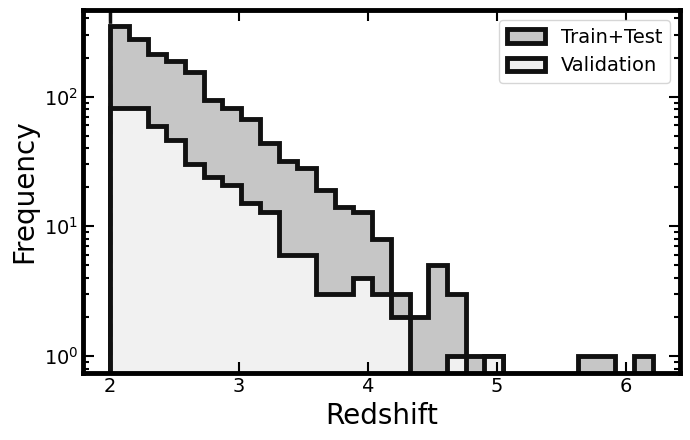

In [35]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=redshift_low_lim, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [36]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [37]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [38]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [39]:
rsd_vals

z_y         395.122945
r_i         180.375045
i_z         154.750487
g_r         136.347063
g_i         118.691636
w1_w2        73.265456
w2_w3        24.803962
Z            19.967191
band_num     17.318649
w3_w4        15.128342
J_H          14.241674
H_K          10.997761
gmag          5.436097
ymag          5.392811
g/J           5.328871
rmag          5.186063
imag          5.148570
zmag          5.115064
i/K           5.104548
r/H           5.073264
W2mproPM      4.188695
W1mproPM      4.069319
w2/w4         3.969809
w1/w4         3.870775
y/W2          3.270655
w1/w3         3.049623
z/W1          2.952883
W3mag         2.130745
i/y           1.977167
r/z           1.788337
W4mag         0.811180
NUVmag        0.697555
Jmag          0.655781
Hmag          0.598605
J/K           0.477297
FUV/K         0.238736
Kmag          0.238528
FUVmag        0.198556
FUV_NUV     -13.233738
dtype: float64

In [40]:
correlation = norm_train_test_df.corr()

In [41]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [42]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [43]:
target_feat = 'Z'

In [44]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [45]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [46]:
list_drop_corr

['i/K',
 'r/H',
 'g/J',
 'w2/w4',
 'w1/w4',
 'Hmag',
 'J/K',
 'FUV_NUV',
 'zmag',
 'imag',
 'W1mproPM',
 'W3mag',
 'Jmag',
 'rmag',
 'W2mproPM',
 'w1/w3',
 'g_i',
 'ymag',
 'i/y']

In [47]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [48]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [49]:
corr_discard = norm_train_test_discard.corr()

In [50]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
Kmag      H_K         0.730000
z/W1      y/W2        0.702122
FUV/K     H_K         0.685413
r_i       r/z         0.644035
FUV/K     Kmag        0.639197
gmag      z/W1        0.626786
r/z       i_z         0.610696
w2_w3     gmag        0.596200
band_num  gmag        0.555715
FUVmag    NUVmag      0.523949
gmag      y/W2        0.522387
w2_w3     band_num    0.518136
w1_w2     Z           0.460377
gmag      w3_w4       0.454569
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

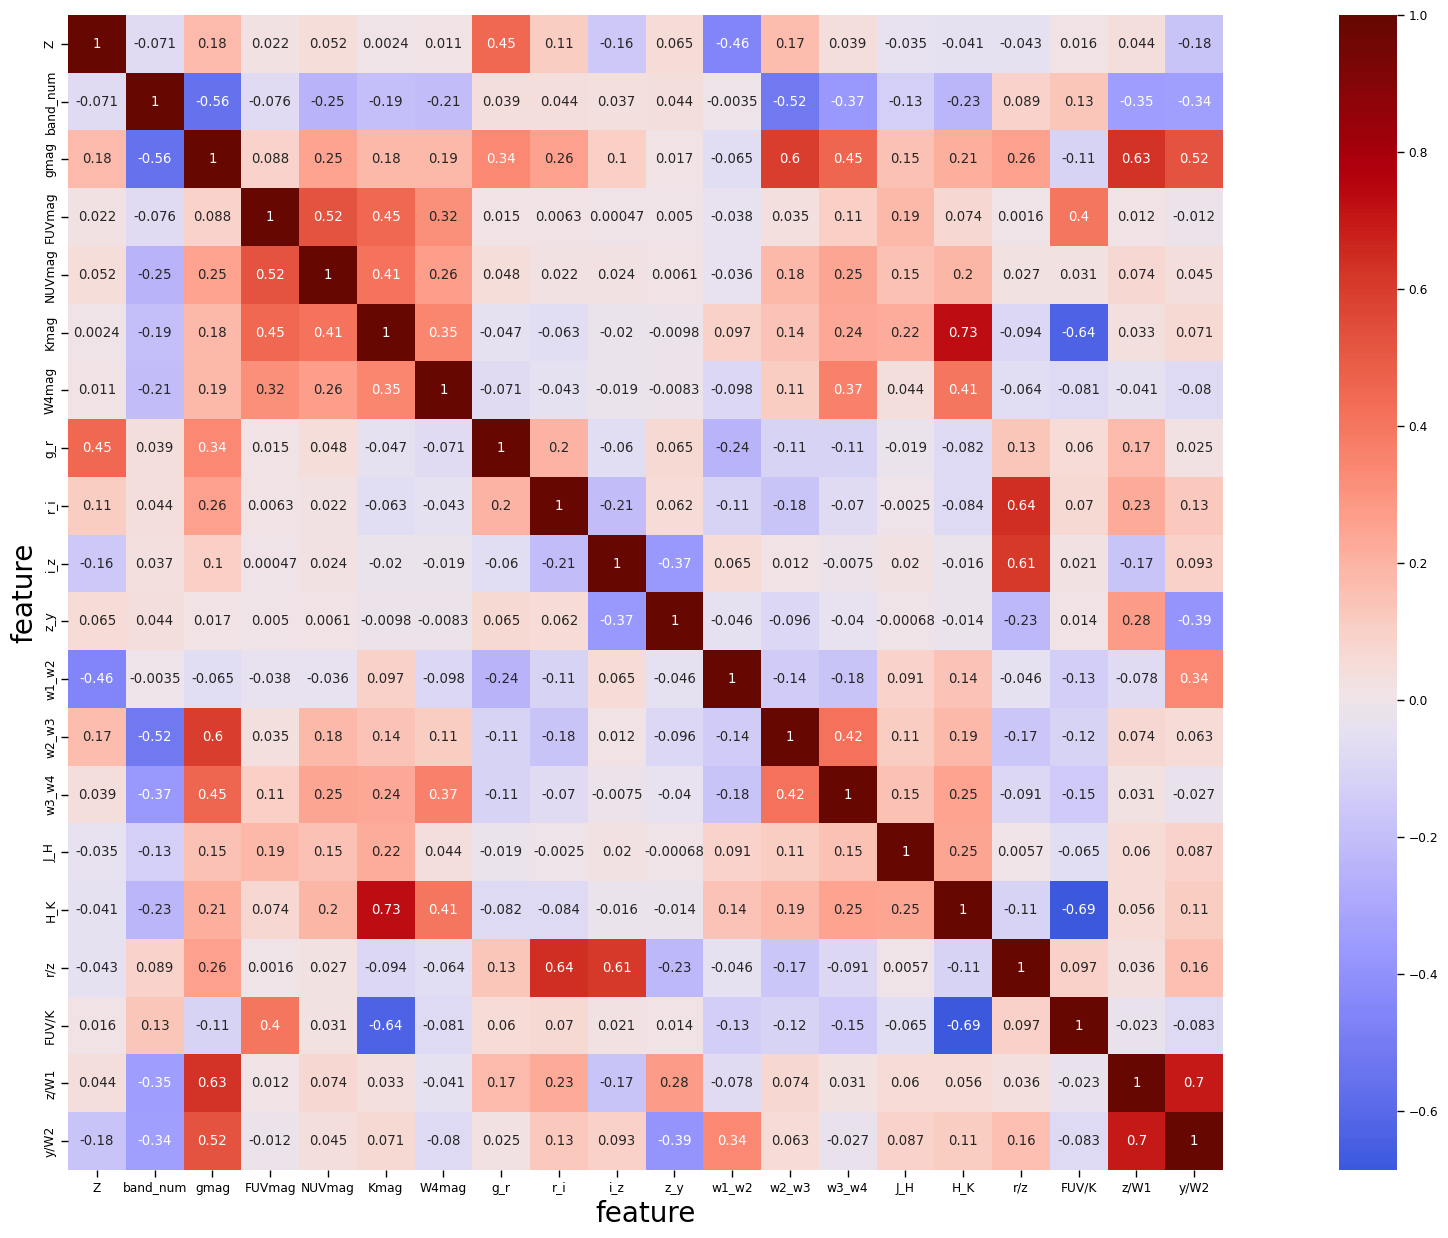

In [51]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [52]:
# norm_train_test_discard.loc[:, 'Z'] = norm_train_test_discard.loc[:, 'Z'].astype(bool)

In [53]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [54]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y    
FUV/K     FUV/K    1.000000
          Kmag     0.777396
Kmag      FUV/K    0.410423
band_num  y/W2     0.293323
          gmag     0.287733
          z_y      0.252411
          w2_w3    0.238258
w3_w4     w2_w3    0.179802
band_num  z/W1     0.139562
gmag      w2_w3    0.109040
w3_w4     gmag     0.086785
y/W2      z/W1     0.058885
z/W1      y/W2     0.057867
band_num  i_z      0.054109
w1_w2     w2_w3    0.047505
z/W1      gmag     0.042835
NUVmag    gmag     0.033054
z_y       y/W2     0.032452
y/W2      w2_w3    0.027804
r/z       i_z      0.023303
dtype: float64

In [55]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [56]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [57]:
target_feat = 'Z'

In [58]:
list_drop_pps = []

In [59]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [60]:
list_drop_pps

['Kmag']

In [61]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [62]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'Z', random_seed=seed)

In [63]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0,regression,True,mean absolute error,0.085834,0.088042,DecisionTreeRegressor()
1,gmag,Z,0,regression,True,mean absolute error,0.085834,0.112658,DecisionTreeRegressor()
2,FUVmag,Z,0,regression,True,mean absolute error,0.085834,0.089563,DecisionTreeRegressor()
3,NUVmag,Z,0,regression,True,mean absolute error,0.085834,0.089844,DecisionTreeRegressor()
4,W4mag,Z,0,regression,True,mean absolute error,0.085834,0.090880,DecisionTreeRegressor()
5,g_r,Z,0,regression,True,mean absolute error,0.085834,0.107309,DecisionTreeRegressor()
6,r_i,Z,0,regression,True,mean absolute error,0.085834,0.119954,DecisionTreeRegressor()
7,i_z,Z,0,regression,True,mean absolute error,0.085834,0.105860,DecisionTreeRegressor()
8,z_y,Z,0,regression,True,mean absolute error,0.085834,0.122748,DecisionTreeRegressor()
9,w1_w2,Z,0,regression,True,mean absolute error,0.085834,0.098319,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [64]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
# z >= 2
# final_feats.remove('band_num')  # After Boruta
# final_feats.remove('FUVmag')  # After Boruta
# final_feats.remove('NUVmag')  # After Boruta
# final_feats.remove('W4mag')  # After Boruta
# final_feats.remove('w3_w4')  # After Boruta
# final_feats.remove('J_H')  # After Boruta
# final_feats.remove('H_K')  # After Boruta
# final_feats.remove('FUV/K')  # After Boruta

In [65]:
# z >= 2
feats_2_discard = list_drop_corr + list_drop_pps#  + ['band_num', 'FUVmag', 'NUVmag', 'W4mag', 'w3_w4', 'J_H', 'H_K', 'FUV/K']

Boruta discards one feature.

In [66]:
exp_radio = pyr.setup(data=train_test_df, target='Z', session_id=seed, silent=True,\
                    feature_selection=True, feature_selection_method='boruta',\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(1600, 39)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1119, 10)"


In [67]:
pyr.get_config('X').columns

Index(['gmag', 'g_r', 'r_i', 'i_z', 'z_y', 'w1_w2', 'w2_w3', 'r/z', 'z/W1',
       'y/W2'],
      dtype='object')

In [68]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [69]:
pyr.add_metric('s_mad',  'sigma_mad',    sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7f0ef89b9310>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [70]:
# z >= 1
final_selection_reg  = ['catboost', 'et', 'rf', 'xgboost', 'gbr', 'dummy']  # knn discarded: no feature importances, avoid lightgbm: slow and high out_fraction
n_models             = 5
top_model_z          = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort='s_mad')  # 1:15 hour for used_models_clf
# top_model_z          = pyr.compare_models(n_select=n_models, sort='s_mmad')  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
catboost,CatBoost Regressor,0.2204,0.1068,0.3202,0.5857,0.0843,0.0854,0.2318,0.0667,0.3202,0.0860,0.0662,0.5680
et,Extra Trees Regressor,0.2219,0.1045,0.3178,0.5916,0.0840,0.0865,0.2335,0.0685,0.3178,0.0857,0.0653,0.2000
rf,Random Forest Regressor,0.2275,0.1139,0.3305,0.5592,0.0871,0.0884,0.2378,0.0686,0.3305,0.0895,0.0697,0.0600
xgboost,Extreme Gradient Boosting,0.2338,0.1200,0.3399,0.5331,0.0894,0.0908,0.2465,0.0703,0.3399,0.0922,0.0787,7.9710
gbr,Gradient Boosting Regressor,0.2330,0.1136,0.3303,0.5600,0.0872,0.0903,0.2541,0.0729,0.3303,0.0887,0.0787,0.0390
dummy,Dummy Regressor,0.3785,0.2554,0.5025,-0.0100,0.1306,0.1433,0.4880,0.1425,0.5025,0.1245,0.2404,0.0080


Thus, we select `lightgbm` as meta learner.

Thus, we stack the models.

In [71]:
stacked_model_z = pyr.stack_models(estimator_list=top_model_z[1:], meta_model=top_model_z[0], optimize='s_mad')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.1914,0.0586,0.2421,0.7327,0.0667,0.0752,0.2278,0.0654,0.2421,0.0666,0.0357
1,0.2478,0.1151,0.3393,0.5551,0.0939,0.0952,0.2487,0.0676,0.3393,0.0931,0.1250
2,0.2075,0.1037,0.3221,0.4727,0.0863,0.0851,0.2235,0.0669,0.3221,0.0963,0.0625
3,0.2293,0.1087,0.3297,0.6204,0.0846,0.0856,0.2179,0.0649,0.3297,0.0849,0.0714
4,0.2548,0.2532,0.5032,0.3751,0.1149,0.0926,0.2234,0.0613,0.5032,0.1136,0.0714
5,0.1873,0.0684,0.2615,0.7138,0.0707,0.0728,0.1641,0.0466,0.2615,0.0706,0.0357
6,0.2142,0.0923,0.3039,0.6124,0.0809,0.0833,0.2377,0.0703,0.3039,0.0816,0.0536
7,0.1814,0.0623,0.2496,0.7097,0.0680,0.0705,0.1822,0.0522,0.2496,0.0694,0.0446
8,0.2577,0.1333,0.3651,0.5083,0.0968,0.1006,0.2849,0.0731,0.3651,0.1020,0.0893


In [72]:
tuned_z_reg = pyr.tune_model(stacked_model_z, early_stopping='asha', optimize='s_mad',\
                               search_library='tune-sklearn', search_algorithm='random')  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.1984,0.0646,0.2542,0.7053,0.0705,0.0787,0.2460,0.0728,0.2542,0.0705,0.0446
1,0.2480,0.1112,0.3335,0.5703,0.0913,0.0948,0.2597,0.0655,0.3335,0.0912,0.1161
2,0.2126,0.1068,0.3268,0.4574,0.0871,0.0859,0.2356,0.0678,0.3268,0.0953,0.0625
3,0.2268,0.1142,0.3379,0.6013,0.0858,0.0838,0.2133,0.0630,0.3379,0.0847,0.0625
4,0.2573,0.2574,0.5073,0.3647,0.1156,0.0940,0.2373,0.0673,0.5073,0.1146,0.0714
5,0.1904,0.0695,0.2636,0.7093,0.0713,0.0742,0.1859,0.0556,0.2636,0.0704,0.0268
6,0.2144,0.0881,0.2969,0.6300,0.0791,0.0831,0.2228,0.0644,0.2969,0.0793,0.0536
7,0.1831,0.0600,0.2449,0.7205,0.0673,0.0712,0.1952,0.0556,0.2449,0.0681,0.0357
8,0.2473,0.1185,0.3443,0.5627,0.0921,0.0964,0.2541,0.0749,0.3443,0.0959,0.0804


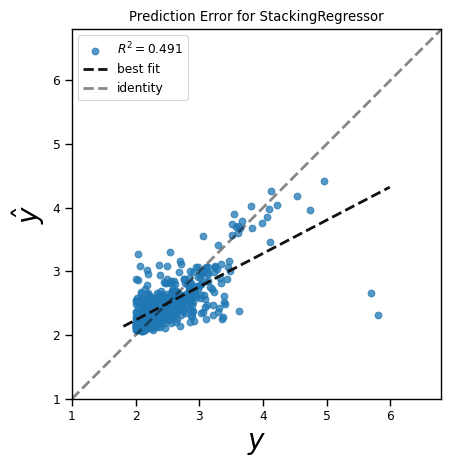

In [73]:
pyr.plot_model(tuned_z_reg, plot='error')

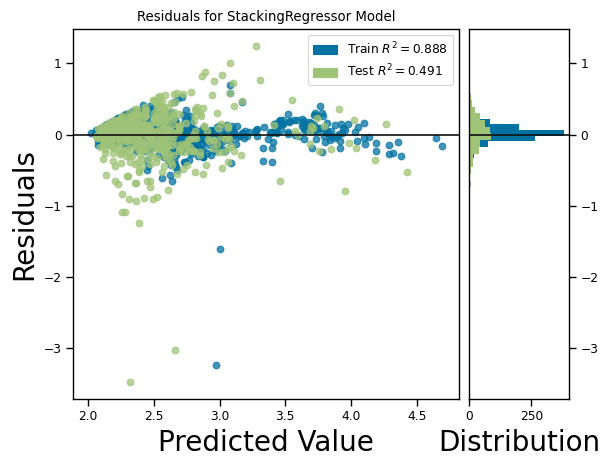

In [74]:
pyr.plot_model(tuned_z_reg, plot='residuals')

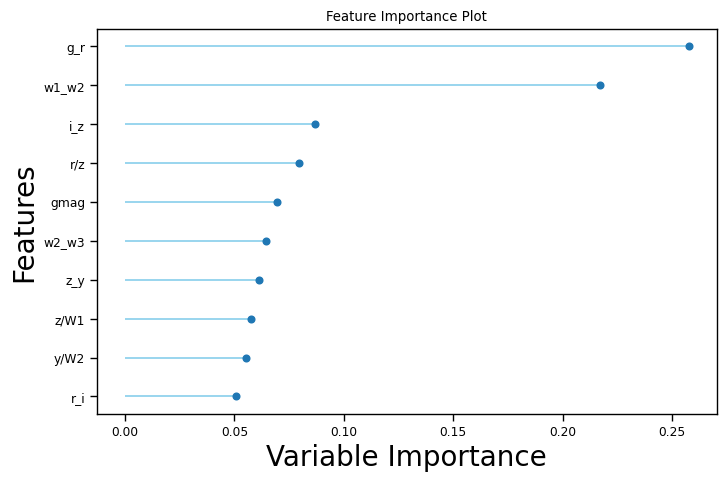

In [75]:
pyr.plot_model(tuned_z_reg.estimators_[0], plot='feature_all')

In [76]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
loss_function,RMSE
depth,9
l2_leaf_reg,30
border_count,254
thread_count,12
verbose,False
random_strength,0.2
task_type,CPU
n_estimators,170
random_state,42


In [77]:
plt.rcParams.update(plt.rcParamsDefault)

In [78]:
pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2262,0.1344,0.3666,0.4908,0.0928,0.0859,0.2189,0.0648,0.3666,0.0884,0.0873


,gmag,g_r,r_i,i_z,z_y,w1_w2,w2_w3,r/z,z/W1,y/W2,Z,Label
0,-1.058772,0.076394,0.008747,-0.071850,-0.099419,-0.719648,-1.745510,0.060536,0.685187,0.373388,2.201,2.551946
1,0.625713,-0.161183,-0.261215,-5.583769,2.023629,-0.010961,1.304667,-6.098807,1.963054,1.050452,3.383,2.608404
2,-0.476144,0.147445,0.443763,-0.098887,0.275442,-0.282901,-0.735720,0.380537,-0.280759,-0.581931,2.372,2.414393
3,-0.074857,-0.461173,-0.230080,0.173839,-0.354736,-0.727461,-0.036638,-0.002532,0.514347,0.350841,2.137,2.375775
4,0.931430,-0.645637,1.343390,-0.376365,0.718357,-0.444314,0.691594,0.813874,0.946128,0.272709,2.350,2.539336
...,...,...,...,...,...,...,...,...,...,...,...,...
476,1.372288,0.654411,-0.852113,-3.090175,2.023629,-0.172509,-0.678226,-3.790334,3.025356,2.490544,2.040,2.431167
477,-0.219401,0.468526,0.224573,-0.060199,-0.136238,-0.098975,-0.740503,0.211379,0.145766,0.142395,2.595,2.383297
478,-0.603846,-0.088028,-1.130856,0.761811,-0.167072,-0.116379,-0.395647,-0.194515,-0.640445,-0.457616,2.595,2.468776
479,-0.337705,-0.051716,1.239142,-0.337414,-0.452465,0.674949,-0.820010,0.872482,-0.586396,0.096489,2.013,2.160418


In [79]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2262,0.1344,0.3666,0.4908,0.0928,0.0859,0.2189,0.0648,0.3666,0.0884,0.0873


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [80]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

In [81]:
if save_model_flag:
    pyr.save_model(final_z_reg, 'models/regression_z_may_18_2022')  # Model (it will be saved with .pkl extension)
    # pyr.save_config('models/config_regression_z_may_18_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    final_z_reg = pyr.load_model('models/regression_z_may_18_2022')

### Prediction process

#### Feature importances

In [82]:
estimators_list = [estimator[0] for estimator in final_z_reg.estimators]

In [83]:
extended_data_z = validation_df.loc[:, get_final_column_names(final_z_reg, validation_df)].copy()
extended_idx_z  = extended_data_z.index
initial_cols_z  = extended_data_z.columns
extended_cols_z = extended_data_z.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_z = extended_cols_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [84]:
print('Running data pre-processing:\n')
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    prep_steps = final_z_reg.named_steps.items()
else:
    prep_steps = pyr.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_z = method.transform(extended_data_z)
extended_data_z_df = pd.DataFrame(extended_data_z, columns=extended_cols_z, index=extended_idx_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [85]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    if hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)
else:
    if hasattr(final_z_reg.final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.final_estimator_.feature_importances_
    elif hasattr(final_z_reg.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_z, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_z))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [86]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    estimators_list  = final_z_reg.named_steps['trained_model'].estimators
    estimators_list_ = final_z_reg.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_z_reg.estimators
    estimators_list_ = final_z_reg.estimators_

In [87]:
base_models_names = [model[0] for model in estimators_list]

In [88]:
coef_sorted_base_df = {}

In [89]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_z.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': np.abs(np.ravel(model_fit.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [90]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [91]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for et...
Calculating for rf...
Calculating for xgboost...
Calculating for gbr...


et                 rf            xgboost                gbr           
  Feature Importance Feature Importance Feature Importance Feature Importance
0     g_r  23.695415     g_r  32.573484     g_r  25.460276     g_r  34.785597
1   w1_w2  20.866239   w1_w2  15.772232   w1_w2  17.561390   w1_w2  20.015921
2     i_z   9.107201     i_z  13.047568     i_z  12.815063     i_z  11.814239
3     r/z   8.221249     z_y   7.337995     r/z  10.449653     r/z   7.559194
4    gmag   7.640767     r/z   6.434530   w2_w3   7.178329    z/W1   6.800032
5     z_y   6.974895    z/W1   6.017790    z/W1   6.678499     z_y   5.102605
6    z/W1   6.292597     r_i   5.675984     z_y   5.649461    gmag   4.639883
7   w2_w3   5.935379    gmag   5.453392    y/W2   5.644837   w2_w3   3.530959
8     r_i   5.772380   w2_w3   3.866910     r_i   4.967896     r_i   2.986308
9    y/W2   5.493880    y/W2   3.820115    gmag   3.594606    y/W2   2.765262

In [92]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,gbr,17.881868
1,et,16.329002
2,gmag,8.082123
3,xgboost,7.153730
4,rf,6.627603
5,g_r,6.413215
6,z_y,5.886175
7,i_z,5.809896
8,r_i,5.398100
9,w1_w2,5.385128


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
g_r	29.129
w1_w2	18.554
i_z	11.696
r/z	8.166
z/W1	6.447
z_y	6.266
gmag	5.332
w2_w3	5.128
r_i	4.851
y/W2	4.431


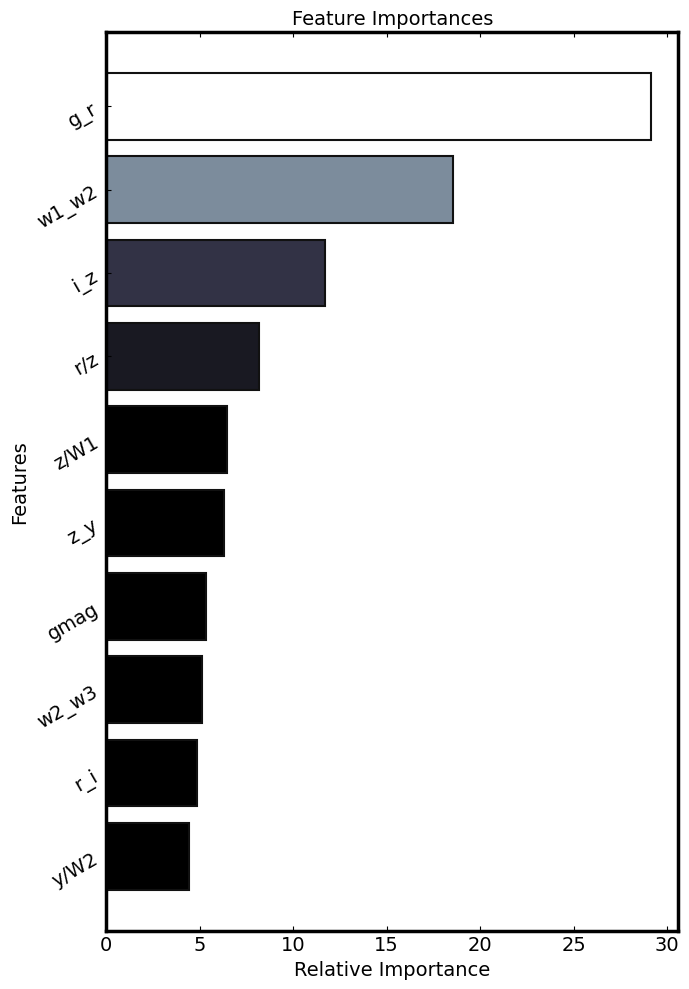

In [93]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_z_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_regression_z_05.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [94]:
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1974,0.0744,0.2728,0.6875,0.0738,0.0784,0.2109,0.0602,0.2728,0.0753,0.0475


In [95]:
validation_prediction_reg.loc[:, ['Z', 'Label']].describe()

,Z,Label
count,400.000000,400.000000
mean,2.526180,2.552286
std,0.488601,0.380063
min,2.000000,2.065365
25%,2.185250,2.311387
50%,2.380500,2.476873
75%,2.737250,2.690129
max,5.000000,4.375284


In [96]:
# clb.vmax

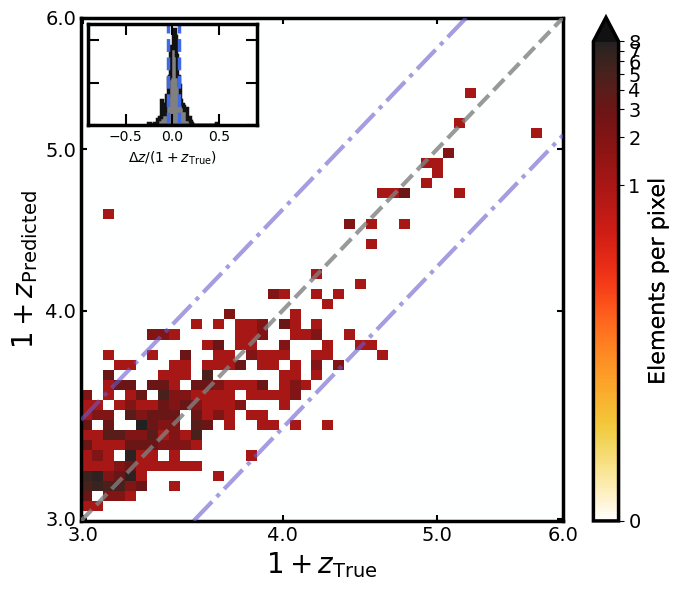

In [97]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 331
norm = ImageNormalize(vmin=0., stretch=LogStretch())

filt_pair_z = np.isfinite(validation_prediction_reg.loc[:, 'Z']) & np.isfinite(validation_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + validation_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + validation_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + validation_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + validation_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (validation_prediction_reg.loc[:, 'Label'] - validation_prediction_reg.loc[:, 'Z']) / (1 + validation_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=2.99, right=np.ceil(max_for_range))
ax1.set_ylim(bottom=2.99, top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/compare_plot_validation_redshift_05.pdf', bbox_inches='tight')
plt.show()

In [98]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns  = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['Z']), train_test_df.loc[:, 'Z'], False, 'Z'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['Z']),
                train_test_df.loc[:, 'Z'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_df        = pd.concat([X_train, y_train], axis=1)
test_df         = pd.concat([X_test, y_test], axis=1)

In [99]:
train_prediction_reg = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg  = pyr.predict_model(final_z_reg, data=test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1174,0.0444,0.2107,0.8258,0.0532,0.0460,0.1115,0.0312,0.2107,0.0532,0.0152


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1201,0.0571,0.2389,0.7839,0.0569,0.0452,0.1055,0.0306,0.2389,0.0525,0.0229


In [100]:
sigma_mad_train    = sigma_mad(train_prediction_reg.loc[:, 'Z'],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test     = sigma_mad(test_prediction_reg.loc[:, 'Z'],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_valid    = sigma_mad(validation_prediction_reg.loc[:, 'Z'],    validation_prediction_reg.loc[:, 'Label'])

In [101]:
sigma_nmad_train   = sigma_nmad(train_prediction_reg.loc[:, 'Z'],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test    = sigma_nmad(test_prediction_reg.loc[:, 'Z'],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid   = sigma_nmad(validation_prediction_reg.loc[:, 'Z'],   validation_prediction_reg.loc[:, 'Label'])

In [102]:
sigma_z_train      = sigma_z(train_prediction_reg.loc[:, 'Z'],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test       = sigma_z(test_prediction_reg.loc[:, 'Z'],            test_prediction_reg.loc[:, 'Label'])
sigma_z_valid      = sigma_z(validation_prediction_reg.loc[:, 'Z'],      validation_prediction_reg.loc[:, 'Label'])

In [103]:
sigma_z_norm_train = sigma_z_norm(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test  = sigma_z_norm(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid = sigma_z_norm(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [104]:
out_frac_train     = outlier_frac(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
out_frac_test      = outlier_frac(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
out_frac_valid     = outlier_frac(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [105]:
print('Scores for training set:')
print(f'Sigma MAD:\t\t{sigma_mad_train:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_train:.4f}')
print(f'Sigma z:\t\t{sigma_z_train:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_train:.4f}')
print(f'Out fraction:\t\t{out_frac_train:.4f}')
print('-' * 35)

Scores for training set:
Sigma MAD:		0.1115
Sigma NMAD:		0.0312
Sigma z:		0.2107
Sigma z norm:		0.0532
Out fraction:		0.0152
-----------------------------------


In [106]:
print('Scores for test set:')
print(f'Sigma MAD:\t\t{sigma_mad_test:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_test:.4f}')
print(f'Sigma z:\t\t{sigma_z_test:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_test:.4f}')
print(f'Out fraction:\t\t{out_frac_test:.4f}')
print('-' * 35)

Scores for test set:
Sigma MAD:		0.1055
Sigma NMAD:		0.0306
Sigma z:		0.2389
Sigma z norm:		0.0525
Out fraction:		0.0229
-----------------------------------


In [107]:
print('Scores for validation set:')
print(f'Sigma MAD:\t\t{sigma_mad_valid:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_valid:.4f}')
print(f'Sigma z:\t\t{sigma_z_valid:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_valid:.4f}')
print(f'Out fraction:\t\t{out_frac_valid:.4f}')
print('-' * 35)

Scores for validation set:
Sigma MAD:		0.2109
Sigma NMAD:		0.0602
Sigma z:		0.2728
Sigma z norm:		0.0753
Out fraction:		0.0475
-----------------------------------


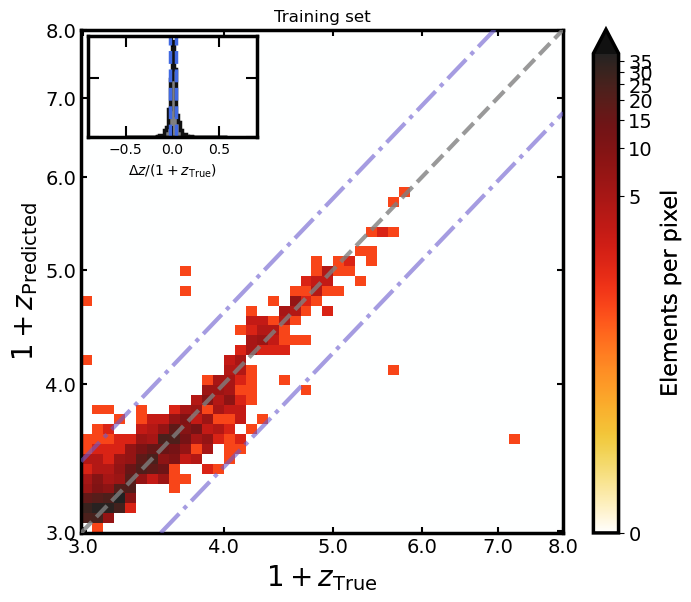

In [108]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 947
norm = ImageNormalize(vmin=0., stretch=LogStretch())

filt_pair_z = np.isfinite(train_prediction_reg.loc[:, 'Z']) & np.isfinite(train_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + train_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + train_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + train_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + train_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (train_prediction_reg.loc[:, 'Label'] - train_prediction_reg.loc[:, 'Z']) / (1 + train_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=2.99, right=np.ceil(max_for_range))
ax1.set_ylim(bottom=2.99, top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
ax1.set_title('Training set')
if save_plot_flag:
    plt.savefig('plots/compare_plot_train_redshift_05.pdf', bbox_inches='tight')
plt.show()

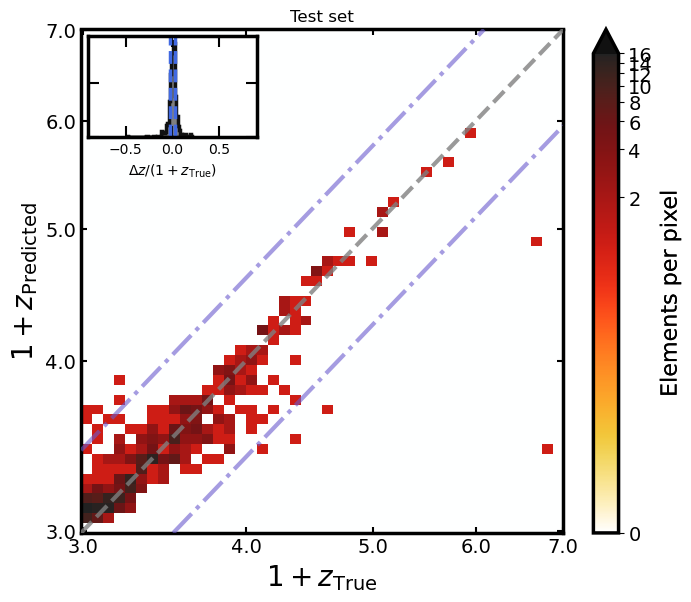

In [109]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 388
norm = ImageNormalize(vmin=0., stretch=LogStretch())

filt_pair_z = np.isfinite(test_prediction_reg.loc[:, 'Z']) & np.isfinite(test_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + test_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + test_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + test_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + test_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (test_prediction_reg.loc[:, 'Label'] - test_prediction_reg.loc[:, 'Z']) / (1 + test_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=2.99, right=np.ceil(max_for_range))
ax1.set_ylim(bottom=2.99, top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
ax1.set_title('Test set')
if save_plot_flag:
    plt.savefig('plots/compare_plot_test_redshift_05.pdf', bbox_inches='tight')
plt.show()

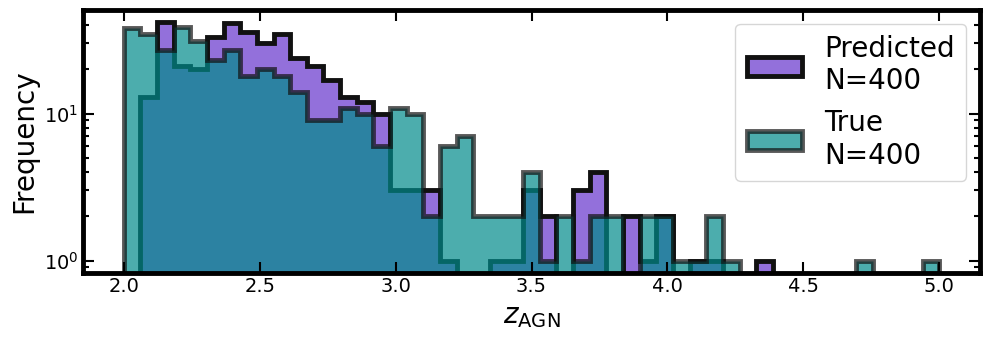

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost

In [110]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, 'Z'], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/hist_true_predicted_z_05.pdf')
plt.show()